In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values (0-255 → 0-1)
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape to add a single channel (for CNNs)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Reduce dataset size (Take only 20% of original data)
sample_fraction = 0.2  # Change this value as needed

# Randomly select a subset of the data
num_train_samples = int(len(x_train) * sample_fraction)
num_test_samples = int(len(x_test) * sample_fraction)

train_indices = np.random.choice(len(x_train), num_train_samples, replace=False)
test_indices = np.random.choice(len(x_test), num_test_samples, replace=False)

x_train_small, y_train_small = x_train[train_indices], y_train[train_indices]
x_test_small, y_test_small = x_test[test_indices], y_test[test_indices]

# Print dataset size after reduction
print(f"Reduced Training Set Size: {x_train_small.shape[0]}")
print(f"Reduced Testing Set Size: {x_test_small.shape[0]}")

Reduced Training Set Size: 12000
Reduced Testing Set Size: 2000


In [ ]:
def build_vgg16_mnist(input_shape=(28, 28, 1), num_classes=10):
    model = models.Sequential()

    # First Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Block
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


In [ ]:
# Build the model
vgg16_model = build_vgg16_mnist()

# Compile the model
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = vgg16_model.fit(x_train_small, y_train_small, epochs=5, batch_size=64, validation_data=(x_test_small, y_test_small))



Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.4318 - loss: 1.5421 - val_accuracy: 0.9620 - val_loss: 0.1175
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.9626 - loss: 0.1108 - val_accuracy: 0.9785 - val_loss: 0.0667
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.9785 - loss: 0.0620 - val_accuracy: 0.9850 - val_loss: 0.0467
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.9858 - loss: 0.0432 - val_accuracy: 0.9795 - val_loss: 0.0682
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.9855 - loss: 0.0417 - val_accuracy: 0.9890 - val_loss: 0.0380


313/313 - 55s - 177ms/step - accuracy: 0.9850 - loss: 0.0548

Test Accuracy: 0.9850


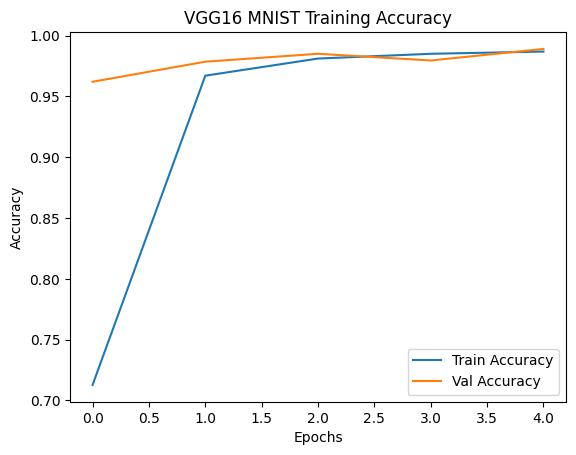

In [ ]:
# Evaluate on Test Set
test_loss, test_acc = vgg16_model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('VGG16 MNIST Training Accuracy')
plt.show()


In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Save the input for skip connection

    # First Convolutional Layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Second Convolutional Layer
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # If dimensions change (due to stride), apply 1x1 convolution to shortcut
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)

    # Skip Connection (Adding Input to Output)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_resnet_mnist(input_shape=(28, 28, 1), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)  # Downsampling

    # Residual Blocks (Ensure stride=2 for downsampling when needed)
    x = resnet_block(x, 32)
    x = resnet_block(x, 32)

    x = resnet_block(x, 64, stride=2)  # Downsampling
    x = resnet_block(x, 64)

    # Global Average Pooling and Output Layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model


In [ ]:
# Build the model
model = build_resnet_mnist()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 261s 224ms/step - accuracy: 0.9047 - loss: 0.3358 - val_accuracy: 0.9680 - val_loss: 0.1081
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 205s 219ms/step - accuracy: 0.9857 - loss: 0.0463 - val_accuracy: 0.9861 - val_loss: 0.0482
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 204s 218ms/step - accuracy: 0.9885 - loss: 0.0365 - val_accuracy: 0.9827 - val_loss: 0.0554
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 260s 216ms/step - accuracy: 0.9911 - loss: 0.0287 - val_accuracy: 0.9833 - val_loss: 0.0554
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 204s 217ms/step - accuracy: 0.9930 - loss: 0.0219 - val_accuracy: 0.9841 - val_loss: 0.0497


313/313 - 9s - 29ms/step - accuracy: 0.9841 - loss: 0.0497

Test Accuracy: 0.9841


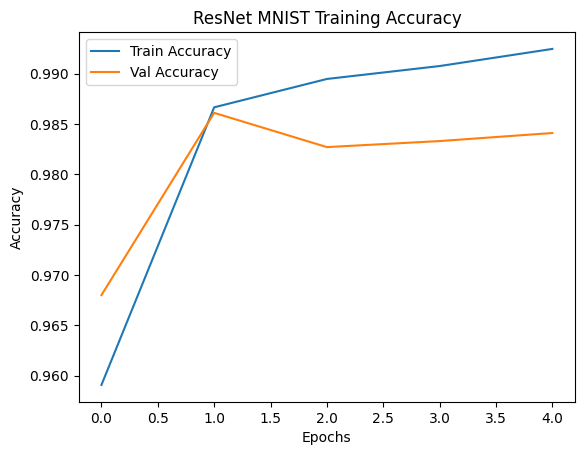

In [ ]:
# Evaluate on Test Set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ResNet MNIST Training Accuracy')
plt.show()
